In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)
from sklearn.model_selection import (GridSearchCV,
                                     TimeSeriesSplit)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from xgboost import plot_importance, plot_tree

c:\Users\augusto.lourencatto\Desktop\me\TCC\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Calibri"
plt.style.use("ggplot")
teal = "#00C0D2"
light_blue = "#4251BC"
blue = "#262E6C"
dark_blue = "#111530"
black = "#000000"
cian = "#4AA6EE"

In [3]:
df_demanda_potencia_full : pd.DataFrame = pd.read_csv('./data/checkpoints/df_full_v1.csv',index_col='Unnamed: 0')
df_demanda_potencia_full.head(2)

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,val_cargaenergiahomwmed
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.7,90.25,95.8,1.48,SE,SUDESTE,28212.46
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.5,92.00,114.0,0.80,SE,SUDESTE,27511.77


In [14]:
df_demanda_potencia_full['Date'] = pd.to_datetime(df_demanda_potencia_full.index)
df_demanda_potencia_full['dataref'] = df_demanda_potencia_full['Date'].dt.strftime("%Y/%m/%d")
df_demanda_potencia_full['ano'] = df_demanda_potencia_full['Date'].dt.year
df_demanda_potencia_full['mes'] = df_demanda_potencia_full['Date'].dt.month
df_demanda_potencia_full['semana'] = df_demanda_potencia_full['Date'].dt.week
df_demanda_potencia_full['dia'] = df_demanda_potencia_full['Date'].dt.day
df_demanda_potencia_full['dia_semana'] = df_demanda_potencia_full['Date'].dt.dayofweek
df_demanda_potencia_full['hora'] = df_demanda_potencia_full['Date'].dt.hour

C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_8500\2912807007.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_demanda_potencia_full['semana'] = df_demanda_potencia_full['Date'].dt.week


In [15]:
## Marcando o pico de potência 
df_demanda_potencia : pd.DataFrame = df_demanda_potencia_full.copy()

df_demanda_potencia["max_executado"] = df_demanda_potencia.groupby("dataref")["val_cargaenergiahomwmed"].transform("max")
df_demanda_potencia["pico"] = (df_demanda_potencia["val_cargaenergiahomwmed"] == df_demanda_potencia["max_executado"])
df_demanda_potencia["pico"] = df_demanda_potencia["pico"].astype(int)

df_demanda_potencia.head(2)
df_demanda_potencia[df_demanda_potencia['pico'] == 1].head(2)

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,...,Date,dataref,ano,mes,semana,dia,dia_semana,hora,max_executado,pico
2012-01-01 21:00:00,0.72,944.0,212.8652,21.12,18.875,90.00,123.6,1.50,SE,SUDESTE,...,2012-01-01 21:00:00,2012/01/01,2012,1,52,1,6,21,33255.76,1
2012-01-02 21:00:00,0.20,945.3,555.6312,22.98,16.850,69.25,172.0,2.24,SE,SUDESTE,...,2012-01-02 21:00:00,2012/01/02,2012,1,1,2,0,21,36982.45,1


C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_8500\4204902929.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)


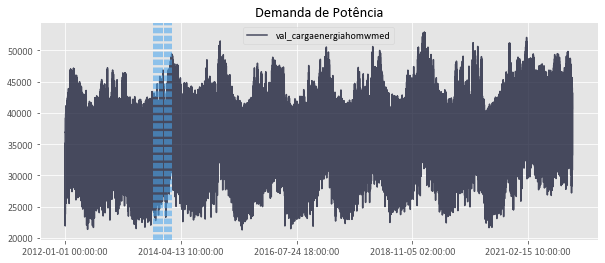

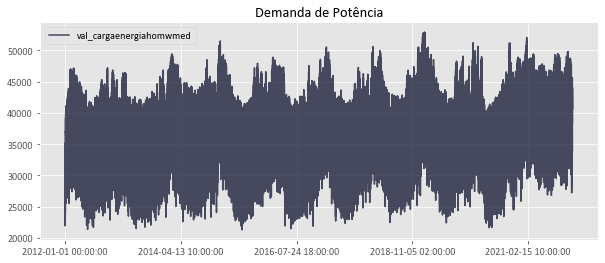

In [16]:
#Plots
ax = df_demanda_potencia.plot(
    y="val_cargaenergiahomwmed", figsize=(10, 4), title="Demanda de Potência", c=dark_blue, alpha=0.75,
)
for y in np.arange(2012, 2021):
    ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
plt.show()

df_demanda_potencia.loc["2012-01-01":"2021-12-31"].plot(
    y="val_cargaenergiahomwmed",
    figsize=(10, 4),
    title="Demanda de Potência",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

# df_demanda_potencia.loc["2020-01-01":"2021-05-01"].plot(
#     y="val_cargaenergiahomwmed",
#     figsize=(10, 4),
#     title="Demanda de Potência 2020 - 2021 (Efeito Covid 19)",
#     c=dark_blue,
#     alpha=0.75,
# )
# plt.show()

# df_demanda_potencia.loc["2021-03-01":"2021-04-01"].plot(
#     y="val_cargaenergiahomwmed",
#     figsize=(10, 4),
#     title="Demanda de Potência Março 2021",
#     c=dark_blue,
#     alpha=0.75,
# )
# plt.show()

# df_demanda_potencia.loc["2021-04-25":"2021-05-01"].plot(
#     y="val_cargaenergiahomwmed",
#     figsize=(10, 4),
#     title="Demanda de Potência 28/04 - 02/05",
#     c=dark_blue,
#     alpha=0.75,
# )

C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_8500\1978748084.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_8500\1978748084.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_8500\1978748084.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_8500\1978748084.py:5: FutureWarning: The pandas.dateti

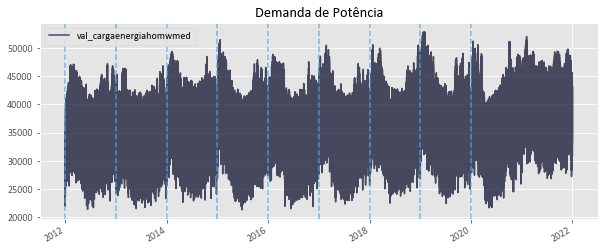

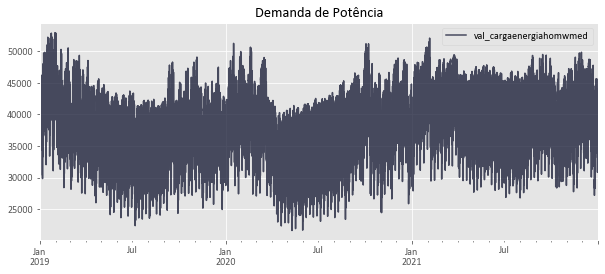

In [31]:
ax = df_demanda_potencia.plot(
    y="val_cargaenergiahomwmed", figsize=(10, 4), title="Demanda de Potência", c=dark_blue, alpha=0.75,
)
for y in np.arange(2012, 2021):
    ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
plt.show()

df_demanda_potencia.loc["2019-01-01":"2021-12-31"].plot(
    y="val_cargaenergiahomwmed",
    figsize=(10, 4),
    title="Demanda de Potência",
    c=dark_blue,
    alpha=0.75,
)
plt.show()

In [17]:
## Modelando o crescimento básico da demanda
df_demanda_potencia["DATE"] = pd.to_datetime(df_demanda_potencia.index)
df_demanda_potencia["ORDINAL_DATE"] = df_demanda_potencia["DATE"].apply(
    lambda x: time.mktime(x.timetuple())
)

lin_regr = LinearRegression(fit_intercept=True)

x = df_demanda_potencia.dropna(subset=["val_cargaenergiahomwmed", "ORDINAL_DATE"])[
    "ORDINAL_DATE"
].values.reshape(-1, 1)
y = df_demanda_potencia.dropna(subset=["val_cargaenergiahomwmed", "ORDINAL_DATE"])["val_cargaenergiahomwmed"].values.reshape(
    -1, 1
)

lin_regr.fit(x, y)
print("LinReg Slope (per timestep):", lin_regr.coef_[0])
print("LinReg Intercept:", lin_regr.intercept_)
print("LinReg Slope (per month):", lin_regr.coef_[0] * 48 * 30)
print("LinReg Slope (per year):", lin_regr.coef_[0] * 48 * 365)

# df_demanda_potencia.head()

LinReg Slope (per timestep): [9.08748983e-06]
LinReg Intercept: [22834.97189732]
LinReg Slope (per month): [0.01308599]
LinReg Slope (per year): [0.15921282]


C:\Users\augusto.lourencatto\AppData\Local\Temp\ipykernel_8500\1311883653.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)


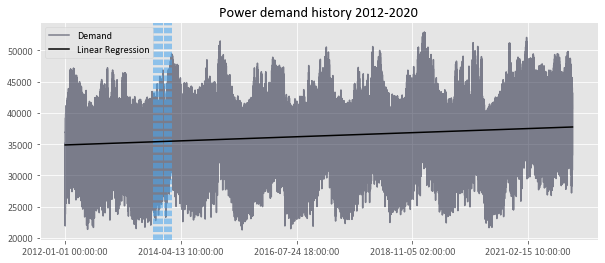

In [18]:
df_demanda_potencia["LINREG"] = lin_regr.predict(
    df_demanda_potencia["ORDINAL_DATE"].values.reshape(-1, 1)
)
ax = df_demanda_potencia.plot(
    y="val_cargaenergiahomwmed",
    figsize=(10, 4),
    title="Power demand history 2012-2020",
    c=dark_blue,
    alpha=0.5,
    label="Demand",
)
for y in np.arange(2012, 2021):
    ax.axvline(pd.datetime(y, 1, 1), c=cian, linestyle="--", alpha=0.75)
df_demanda_potencia.plot(y="LINREG", figsize=(10, 4), c="k", ax=ax, label="Linear Regression")
plt.show()

c:\Users\augusto.lourencatto\Desktop\me\TCC\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribuição de Probabilidade da Demanda ')

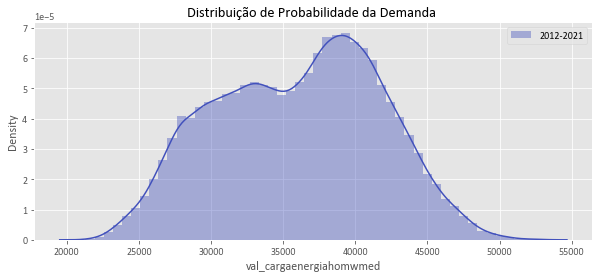

In [19]:
## Analisando a distribuição da demanda
#TODO: Fazer para todos os anos

ax = sns.distplot(
    df_demanda_potencia.loc["2012-01-01":"2021-01-31"]["val_cargaenergiahomwmed"], label="2012-2021", color=light_blue,
)

# sns.distplot(
#     df_demanda_potencia.loc["2019-01-01":"2020-01-01"]["executado"],
#     label="2019",
#     color=blue,
#     ax=ax,
# )
# sns.distplot(
#     df_demanda_potencia.loc["2020-01-01":"2021-01-01"]["executado"],
#     label="2020",
#     color=teal,
#     ax=ax,
# )
# sns.distplot(
#     df_demanda_potencia.loc["2021-01-01":"2021-05-01"]["executado"],
#     label="2021",
#     color=black,
#     ax=ax,
# )
ax.legend()
ax.set_title("Distribuição de Probabilidade da Demanda ")

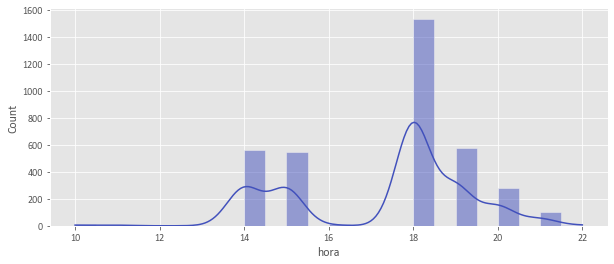

In [20]:
#Como se dá a ocorrência dos picos ao longo dos anos?
#TODO: Fazer para todos os anos
df_demanda_pico = df_demanda_potencia[df_demanda_potencia["pico"] == 1].copy()


ax = sns.histplot(
    df_demanda_pico.loc["2012-01-01":"2021-12-31"]["hora"], label="2018", color=light_blue, kde=True
)
# sns.histplot(
#     df_demanda_pico.loc["2019-01-01":"2020-01-01"]["hora"], label="2019", color=blue, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2020-01-01":"2021-01-01"]["hora"], label="2020", color=teal, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2021-01-01":"2021-05-01"]["hora"], label="2021", color=black, ax=ax,kde=True
# )

# ax.legend()

In [75]:
# #Plot do primeiro semestre de cada ano
# ax = sns.histplot(
#     df_demanda_pico.loc["2018-01-01":"2018-05-01"]["hora"], label="2018", color=light_blue, kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2019-01-01":"2019-05-01"]["hora"], label="2019", color=blue, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2020-01-01":"2020-05-01"]["hora"], label="2020", color=teal, ax=ax,kde=True
# )
# sns.histplot(
#     df_demanda_pico.loc["2021-01-01":"2021-05-01"]["hora"], label="2021", color=black, ax=ax,kde=True
# )

In [76]:
#TODO: Fazer para os dados de temperatura também

In [21]:
#Criando a feature de feriado de mais algumas datas, além das autocorrelacionadas

feriados = holidays.Brazil
dates_of_holidays = []
for date, name in sorted(
    holidays.Brazil(
        years=[2012,2013,2014,2015,2016,2017,2018,2019, 2020, 2021,2022]
    ).items()
):
    dates_of_holidays.append(date)

df_demanda_potencia.index = pd.DatetimeIndex(df_demanda_potencia.index)

df_demanda_potencia['temp'] = df_demanda_potencia.index.to_pydatetime()

# df_demanda_potencia['date'] = df_demanda_potencia['temp'].apply(lambda t: t.date())

df_demanda_potencia["Holiday"] = df_demanda_potencia['temp'].apply(lambda t: 1 if t.date() in dates_of_holidays else 0)
df_demanda_potencia["Quarter"] = df_demanda_potencia["temp"].apply(lambda t: t.quarter)
df_demanda_potencia["DayOfYear"] = df_demanda_potencia["temp"].apply(lambda t: t.dayofyear)
df_demanda_potencia["WeekOfYear"] = df_demanda_potencia["temp"].apply(lambda t: t.weekofyear)

#LAG
df_demanda_potencia['lag_1'] = df_demanda_potencia['val_cargaenergiahomwmed'].shift(1, freq = 'D')
df_demanda_potencia['lag_7'] = df_demanda_potencia['val_cargaenergiahomwmed'].shift(7, freq = 'D')
df_demanda_potencia['lag_14'] = df_demanda_potencia['val_cargaenergiahomwmed'].shift(14, freq = 'D')
df_demanda_potencia['rolling_mean_1'] = df_demanda_potencia['val_cargaenergiahomwmed'].rolling(window=96).mean()
df_demanda_potencia['rolling_mean_7'] = df_demanda_potencia['val_cargaenergiahomwmed'].rolling(window=672).mean()
df_demanda_potencia['rolling_mean_14'] = df_demanda_potencia['val_cargaenergiahomwmed'].rolling(window=1344).mean()


df_demanda_potencia.drop(columns=["temp"], inplace=True)

In [22]:
df_demanda_potencia.columns

Index(['precipitacao_total', 'pressao_atmosferica', 'radiacao_global',
       'temperatura_ar', 'temperatura_ponto_carvalho', 'umidade_relativa_ar',
       'vento_direcao', 'velocidade_vento', 'id_subsistema', 'nom_subsistema',
       'val_cargaenergiahomwmed', 'Date', 'dataref', 'ano', 'mes', 'semana',
       'dia', 'dia_semana', 'hora', 'max_executado', 'pico', 'DATE',
       'ORDINAL_DATE', 'LINREG', 'Holiday', 'Quarter', 'DayOfYear',
       'WeekOfYear', 'lag_1', 'lag_7', 'lag_14', 'rolling_mean_1',
       'rolling_mean_7', 'rolling_mean_14'],
      dtype='object')

In [23]:
# TODO: (DOING) Criar feature de el nino e la nina

# REFERENCIA : http://enos.cptec.inpe.br/#
ocorrencias_el_nino : list = [2015,2016] #Forte
ocorrencias_la_nina : list = [2017,2018] #Fraca

df_demanda_potencia['el_nino'] = df_demanda_potencia.apply(lambda t: 1 if t['ano'] in ocorrencias_el_nino else 0,axis=1)
df_demanda_potencia['la_nina'] = df_demanda_potencia.apply(lambda t: 1 if t['ano'] in ocorrencias_la_nina else 0,axis=1)

In [95]:
df_demanda_potencia.head()

,precipitacao_total,pressao_atmosferica,radiacao_global,temperatura_ar,temperatura_ponto_carvalho,umidade_relativa_ar,vento_direcao,velocidade_vento,id_subsistema,nom_subsistema,...,DayOfYear,WeekOfYear,lag_1,lag_7,lag_14,rolling_mean_1,rolling_mean_7,rolling_mean_14,el_nino,la_nina
2012-01-01 00:00:00,0.88,947.22,-2.8518,21.70,19.700,90.25,95.8,1.48,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 01:00:00,2.00,947.30,-2.4346,21.24,19.500,92.00,114.0,0.80,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 02:00:00,1.24,947.00,-2.3902,21.38,19.775,92.25,159.2,0.62,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 03:00:00,0.44,946.26,-2.2756,21.34,19.425,91.00,178.4,0.46,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2012-01-01 04:00:00,0.32,945.56,-2.2820,21.18,19.775,94.00,116.8,0.32,SE,SUDESTE,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [24]:
df_demanda_potencia.to_csv("./data/checkpoints/df_demanda_potencia_v2.csv")

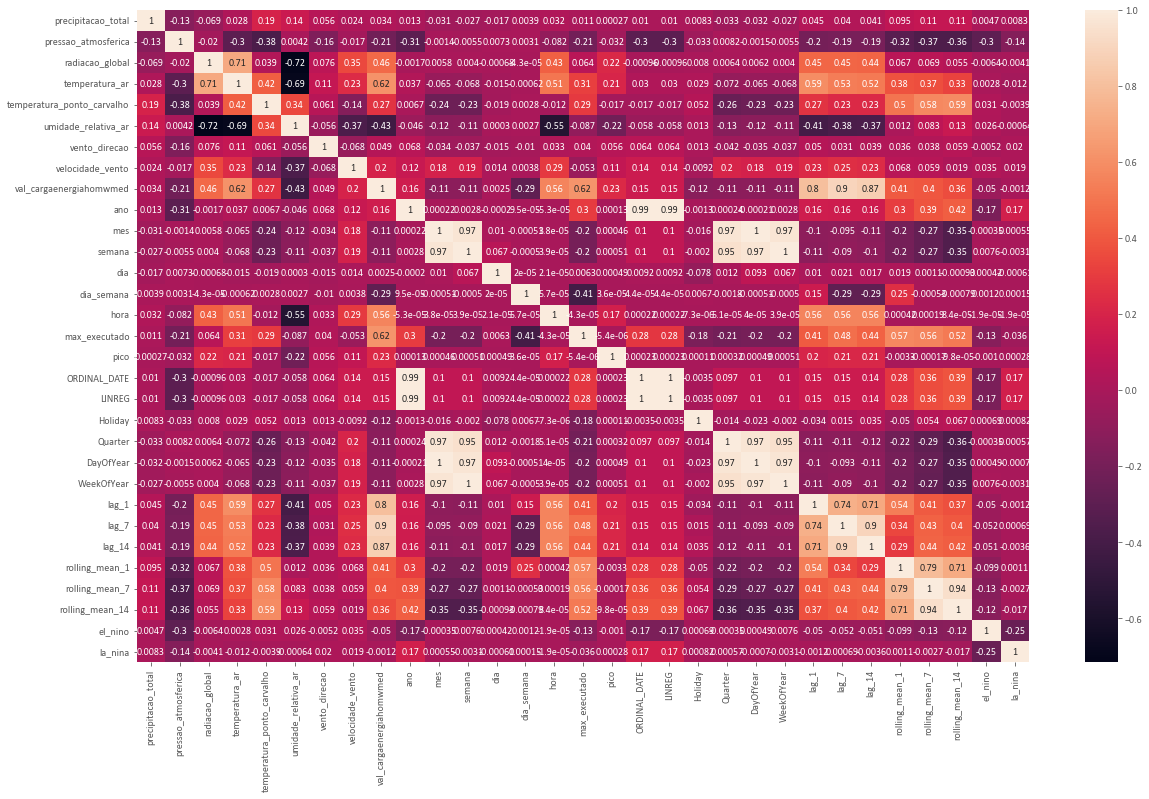

In [25]:
plt.figure(figsize=(20,12))
corr = df_demanda_potencia.corr()
sns.heatmap(corr, annot=True)
plt.show()